### 1. What Linear Regression training algorithm can you use if you have a training set with millions of features?


A: Stochastic Gradient Descent - unlike Batch Grad Descent which uses the whole training set therefore scales poorly, it picks a random observation for each iteration so can be used to train linear models with large training data.

It also has the advantage that because of the random point selection, it can escape local minima. But it will not settle at the global minimum. 

One strategy might be to run stochastic to get an approximation of the global minimum, then run batch on a much smaller area of the search space, meaning it will take fewer iterations to find the true global minimum that if batch was used alone.

Mini batch could be used as well as it selects a random sample of the larger dataset. It will get closer than stocastic, but is more likely to get stuck in local minima



### 2. Suppose the features in your training set have very different scales. What algorithms might suffer from this, and how? What can you do about it?


This will distort the seach space, so gradient descent approaches may take longer to converge

As model coeffients are sensitive to the scale, any method that seeks to "budget" the coeffients in some way such as ridge, lasso or elastic net will suffer.

The way to get around this is to normalise variables using a scaling method. This means coefficients are comparable and regularisation methods can be used. 

### 3. Can Gradient Descent get stuck in a local minimum when training a Logistic Regression model?


No - the search space is convex- no local, only global minima so it cannot get stuck

### 4. Do all Gradient Descent algorithms lead to the same model provided you let them run long enough?


No, stocstic gradient descent is randomised, therefore will only converge on an approximation of the best model.

Others can get stuck in local minima if the learning rate is set too low.

### 5.Suppose you use Batch Gradient Descent and you plot the validation error at every epoch. If you notice that the validation error consistently goes up, what is likely going on? How can you fix this?


Learning rate too high - the solution from each iteration is jumping around and is not converging on a solution. Reduce the learning rate to explore further solutions.

Overfitting - the model has already found the best solution. The algorithm should be stopped earlier

## 6. Is it a good idea to stop Mini-batch Gradient Descent immediately when the validation error goes up?


No - both use random selection or sample from the data, so validation error going up may be due to the change in sample for that iteration. 

### 7. Which Gradient Descent algorithm (among those we discussed) will reach the vicinity of the optimal solution the fastest? Which will actually converge? How can you make the others converge as well?


not sure if it means time or number of iterations here. 

Stocastic will be fastest as it only uses one observation. Mini batch nex as it only uses a subsample.

These will not get to the optimum due to the randomness however, so gradient or batch may get to the optimum in fewest iterations unless simulated annealing is used

## 8. Suppose you are using Polynomial Regression. You plot the learning curves and you notice that there is a large gap between the training error and the validation error. What is happening? What are three ways to solve this?


Overfitting

- reduce complexity of model; fewer degrees
- reduce learning rate if using gradient descent
- use regularisation methods
- more data

### 9. Suppose you are using Ridge Regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regularization hyperparameter α or reduce it?


Underfitting, choosing too few features that correlate with the predictor. Reduce $\alpha$ to decrease how strongly ridge penalises larger models

### 10. Why would you want to use:

    Ridge Regression instead of plain Linear Regression (i.e., without any regularization)?

    Lasso instead of Ridge Regression?

    Elastic Net instead of Lasso?



Reduce overfitting, especially with larger datasets with more features.

Lasso is better if the model is sparse - only a few features correlate with the predictor, but you are not sure which ones

Lasso gives inconsistent results as coeffiencets 'jump' to 0 rather than gradually reduce. Elastic Net combines ridge and lasso which reduces this behaviour

### 11. Suppose you want to classify pictures as outdoor/indoor and daytime/nighttime. Should you implement two Logistic Regression classifiers or one Softmax Regression classifier?


this is a multilabel problem, so two logisitic classifiers, one for night day and one for indoor/outdoor

### 12. Implement Batch Gradient Descent with early stopping for Softmax Regression (without using Scikit-Learn).


In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from tqdm import tqdm_notebook

np.random.seed(42)

In [81]:
iris = datasets.load_iris()

In [82]:
X = iris["data"]  # petal length, petal width
y = iris["target"]

In [83]:
X_bias = np.concatenate([np.ones([len(X), 1]), X],axis=1)

In [80]:
def split_data(data, target, test_frac=0.2):
    """
    Args:
        data (numpy array): contains the data to split
        target (numpy array): vector containing the target variables
        test_frac: ratio of test set size 
    Returns:
        tuple of numpy arrays in the order of training features,
        test features, training target and test target variables
        
    replacement for train_test_split in sklearn
    """
    # put it all together and shuffle
    all_data = np.concatenate([target.reshape(-1,1),data],axis=1)
    np.random.shuffle(all_data)
    
    # get the size of the test set
    data_size = all_data.shape[0]
    test_size = np.round(data_size*test_frac).astype(int)
    
    # slice up the data to get our train test splits for x and y
    y_test = all_data[:test_size,0]
    x_test = all_data[:test_size,1:]
    y_train = all_data[test_size:,0]
    x_train = all_data[test_size:,1:]
        
    return x_train, x_test, y_train, y_test
    
    

In [123]:
def softmax(x):
    """
    implements softmax function
    math::
        \sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}
    
    Args:
        x (numpy array): array of logits
    
    returns: softmax function results for input array x
    """
    return np.exp(x)/np.sum(np.exp(x),
                            axis=1,
                            keepdims=True)

In [131]:
def cross_entropy(p_hat, y, epsilon=1e-9):
    """
    Implements cross entropy cost function as below
    math::
        J(\Theta)=-\frac{1}{m}\sum^m_{i=1}\sum^K_{k=1}y^i_klog(\hat{p}^i_k)
    
    Args: 
        p_hat (numpy array): predicted probabilities for classes
        y (numpy array): target (correct) probabilites for all classes
            should be one-hot in most cases
        epsilon (float): very small number added to p_hat to avoid NaNs returned from
            log function
    
    returns:
        (numpy array) cross entropy of inputs p_hat and y
    """
    return -np.mean(np.sum(y*np.log(p_hat+epsilon)))
    

In [92]:
x_train, x_test, y_train, y_test = split_data(X_bias, y, 0.2)

In [93]:
x_train, x_test, y_train, y_test = split_data(X_bias, y, 0.2)

In [249]:
def batch_grad_desc(X,
                    y,
                    x_valid=None,
                    y_valid=None,
                    eta=0.01,
                    n_iter = 5000,
                    model = softmax,
                    cost = cross_entropy,
                    report_frequency = 500,
                    regularisation=True,
                    alpha = 0.1,
                    early_stopping=True
                   ):
    
    #first guess at our model parameters
    params = np.random.randn(X.shape[1],
                             len(np.unique(y))
                            )
    
    y_one_hot = pd.get_dummies(y).values
    
    if early_stopping:
        y_valid_one_hot = pd.get_dummies(y_valid).values
        
    best = np.Infinity
    cost_valid = np.Infinity
    
    costs = []
    
    for i in tqdm_notebook(range(n_iter)):
        logits = X.dot(params)
        y_estimates = model(logits)
        costs.append(cost(y_estimates, y_one_hot))
        
        if regularisation:
            l2 = alpha*(1/2*np.sum(np.square(params)))
            costs[-1] = costs[-1]*l2
            
        errors = y_estimates-y_one_hot
        gradients = 1/X.shape[1]*X.T.dot(errors)
        params = params - eta*gradients
        
        if early_stopping:
            logits_valid = x_valid.dot(params)
            y_valid_estimates = model(logits_valid)
            cost_valid = cost(y_valid_estimates, y_valid_one_hot)
            
            if (cost_valid  < best):
                best = cost_valid
            else:
                print("Early Stopping!")
                print(f"iteration: {i-1}")
                print(f"entropy loss: {best}\n")
                break
            
        if i % report_frequency ==0: 
            print(f"iteration: {i}")
            print(f"entropy loss: {costs[-1]}\n")
            
        
    return params, costs

In [220]:
def validate_model(params,
                   x,
                   y,
                   model = softmax):
    
    logits = x.dot(params)
    y_probs = model(logits)
    predicted = np.argmax(y_probs, axis=1)
    
    return np.mean(predicted == y)
    

In [230]:
params, costs = batch_grad_desc(x_train,
                                y_train, 
                                n_iter=5000, 
                                report_frequency=500,
                                regularisation=False,
                                early_stopping=False
                               )

Early Stopping!
iteration: 0
entropy loss: 980.7518633778932

iteration: 0
entropy loss: 980.7518633778932

Early Stopping!
iteration: 1
entropy loss: 867.7888389016457

Early Stopping!
iteration: 2
entropy loss: 776.1600687111746

Early Stopping!
iteration: 3
entropy loss: 448.30933282632975

Early Stopping!
iteration: 4
entropy loss: 588.0628291045289

Early Stopping!
iteration: 5
entropy loss: 432.43440813559937

Early Stopping!
iteration: 6
entropy loss: 206.2890988579493

Early Stopping!
iteration: 7
entropy loss: 403.5449112705156

Early Stopping!
iteration: 8
entropy loss: 248.29141349396724

Early Stopping!
iteration: 9
entropy loss: 225.7321321274856

Early Stopping!
iteration: 10
entropy loss: 94.05814164825323

Early Stopping!
iteration: 11
entropy loss: 242.60448729277823

Early Stopping!
iteration: 12
entropy loss: 282.7292104072386

Early Stopping!
iteration: 13
entropy loss: 186.13252470531512

Early Stopping!
iteration: 14
entropy loss: 246.45865042908596

Early Stoppin

Early Stopping!
iteration: 619
entropy loss: 8.466089474607337

Early Stopping!
iteration: 620
entropy loss: 8.462258050719333

Early Stopping!
iteration: 621
entropy loss: 8.458433874137514

Early Stopping!
iteration: 622
entropy loss: 8.454616921191182

Early Stopping!
iteration: 623
entropy loss: 8.450807168327918

Early Stopping!
iteration: 624
entropy loss: 8.447004592112714

Early Stopping!
iteration: 625
entropy loss: 8.44320916922712

Early Stopping!
iteration: 626
entropy loss: 8.439420876468375

Early Stopping!
iteration: 627
entropy loss: 8.435639690748571

Early Stopping!
iteration: 628
entropy loss: 8.431865589093789

Early Stopping!
iteration: 629
entropy loss: 8.428098548643298

Early Stopping!
iteration: 630
entropy loss: 8.424338546648716

Early Stopping!
iteration: 631
entropy loss: 8.420585560473214

Early Stopping!
iteration: 632
entropy loss: 8.41683956759067

Early Stopping!
iteration: 633
entropy loss: 8.413100545584914

Early Stopping!
iteration: 634
entropy los

Early Stopping!
iteration: 1196
entropy loss: 7.00894785166648

Early Stopping!
iteration: 1197
entropy loss: 7.007253487903435

Early Stopping!
iteration: 1198
entropy loss: 7.005560969156138

Early Stopping!
iteration: 1199
entropy loss: 7.003870292082535

Early Stopping!
iteration: 1200
entropy loss: 7.0021814533490385

Early Stopping!
iteration: 1201
entropy loss: 7.000494449630496

Early Stopping!
iteration: 1202
entropy loss: 6.998809277610139

Early Stopping!
iteration: 1203
entropy loss: 6.9971259339795955

Early Stopping!
iteration: 1204
entropy loss: 6.995444415438827

Early Stopping!
iteration: 1205
entropy loss: 6.993764718696121

Early Stopping!
iteration: 1206
entropy loss: 6.992086840468058

Early Stopping!
iteration: 1207
entropy loss: 6.990410777479498

Early Stopping!
iteration: 1208
entropy loss: 6.98873652646351

Early Stopping!
iteration: 1209
entropy loss: 6.987064084161421

Early Stopping!
iteration: 1210
entropy loss: 6.985393447322693

Early Stopping!
iteration

Early Stopping!
iteration: 1819
entropy loss: 6.214341435838289

Early Stopping!
iteration: 1820
entropy loss: 6.2133738445164175

Early Stopping!
iteration: 1821
entropy loss: 6.21240697886832

Early Stopping!
iteration: 1822
entropy loss: 6.211440837986932

Early Stopping!
iteration: 1823
entropy loss: 6.210475420966794

Early Stopping!
iteration: 1824
entropy loss: 6.209510726904009

Early Stopping!
iteration: 1825
entropy loss: 6.2085467548962665

Early Stopping!
iteration: 1826
entropy loss: 6.207583504042834

Early Stopping!
iteration: 1827
entropy loss: 6.206620973444538

Early Stopping!
iteration: 1828
entropy loss: 6.205659162203785

Early Stopping!
iteration: 1829
entropy loss: 6.204698069424541

Early Stopping!
iteration: 1830
entropy loss: 6.203737694212332

Early Stopping!
iteration: 1831
entropy loss: 6.202778035674234

Early Stopping!
iteration: 1832
entropy loss: 6.2018190929188854

Early Stopping!
iteration: 1833
entropy loss: 6.2008608650564785

Early Stopping!
iterat

Early Stopping!
iteration: 2374
entropy loss: 5.768158393834311

Early Stopping!
iteration: 2375
entropy loss: 5.767488352360845

Early Stopping!
iteration: 2376
entropy loss: 5.766818704046938

Early Stopping!
iteration: 2377
entropy loss: 5.766149448507724

Early Stopping!
iteration: 2378
entropy loss: 5.765480585358878

Early Stopping!
iteration: 2379
entropy loss: 5.764812114216587

Early Stopping!
iteration: 2380
entropy loss: 5.764144034697558

Early Stopping!
iteration: 2381
entropy loss: 5.763476346419049

Early Stopping!
iteration: 2382
entropy loss: 5.762809048998812

Early Stopping!
iteration: 2383
entropy loss: 5.762142142055131

Early Stopping!
iteration: 2384
entropy loss: 5.761475625206822

Early Stopping!
iteration: 2385
entropy loss: 5.760809498073213

Early Stopping!
iteration: 2386
entropy loss: 5.760143760274138

Early Stopping!
iteration: 2387
entropy loss: 5.75947841142998

Early Stopping!
iteration: 2388
entropy loss: 5.75881345116162

Early Stopping!
iteration: 

Early Stopping!
iteration: 3009
entropy loss: 5.408372523033754

Early Stopping!
iteration: 3010
entropy loss: 5.407892160455374

Early Stopping!
iteration: 3011
entropy loss: 5.4074120234545315

Early Stopping!
iteration: 3012
entropy loss: 5.406932111854328

Early Stopping!
iteration: 3013
entropy loss: 5.406452425478068

Early Stopping!
iteration: 3014
entropy loss: 5.405972964149262

Early Stopping!
iteration: 3015
entropy loss: 5.405493727691584

Early Stopping!
iteration: 3016
entropy loss: 5.405014715928932

Early Stopping!
iteration: 3017
entropy loss: 5.404535928685383

Early Stopping!
iteration: 3018
entropy loss: 5.404057365785196

Early Stopping!
iteration: 3019
entropy loss: 5.403579027052849

Early Stopping!
iteration: 3020
entropy loss: 5.403100912312983

Early Stopping!
iteration: 3021
entropy loss: 5.4026230213904665

Early Stopping!
iteration: 3022
entropy loss: 5.402145354110316

Early Stopping!
iteration: 3023
entropy loss: 5.40166791029778

Early Stopping!
iteratio

Early Stopping!
iteration: 3586
entropy loss: 5.163818760841461

Early Stopping!
iteration: 3587
entropy loss: 5.163444299026528

Early Stopping!
iteration: 3588
entropy loss: 5.1630699860029665

Early Stopping!
iteration: 3589
entropy loss: 5.162695821671967

Early Stopping!
iteration: 3590
entropy loss: 5.162321805934794

Early Stopping!
iteration: 3591
entropy loss: 5.161947938692823

Early Stopping!
iteration: 3592
entropy loss: 5.161574219847527

Early Stopping!
iteration: 3593
entropy loss: 5.161200649300449

Early Stopping!
iteration: 3594
entropy loss: 5.160827226953233

Early Stopping!
iteration: 3595
entropy loss: 5.160453952707616

Early Stopping!
iteration: 3596
entropy loss: 5.160080826465441

Early Stopping!
iteration: 3597
entropy loss: 5.159707848128608

Early Stopping!
iteration: 3598
entropy loss: 5.159335017599136

Early Stopping!
iteration: 3599
entropy loss: 5.158962334779112

Early Stopping!
iteration: 3600
entropy loss: 5.158589799570747

Early Stopping!
iteratio

iteration: 4188
entropy loss: 4.962169600765047

Early Stopping!
iteration: 4189
entropy loss: 4.961869652406158

Early Stopping!
iteration: 4190
entropy loss: 4.961569806713986

Early Stopping!
iteration: 4191
entropy loss: 4.961270063629754

Early Stopping!
iteration: 4192
entropy loss: 4.960970423094712

Early Stopping!
iteration: 4193
entropy loss: 4.960670885050176

Early Stopping!
iteration: 4194
entropy loss: 4.960371449437474

Early Stopping!
iteration: 4195
entropy loss: 4.9600721161980275

Early Stopping!
iteration: 4196
entropy loss: 4.959772885273285

Early Stopping!
iteration: 4197
entropy loss: 4.959473756604715

Early Stopping!
iteration: 4198
entropy loss: 4.9591747301338795

Early Stopping!
iteration: 4199
entropy loss: 4.958875805802341

Early Stopping!
iteration: 4200
entropy loss: 4.958576983551765

Early Stopping!
iteration: 4201
entropy loss: 4.958278263323804

Early Stopping!
iteration: 4202
entropy loss: 4.957979645060191

Early Stopping!
iteration: 4203
entropy

Early Stopping!
iteration: 4828
entropy loss: 4.788927921786483

Early Stopping!
iteration: 4829
entropy loss: 4.788683417840705

Early Stopping!
iteration: 4830
entropy loss: 4.788438986814325

Early Stopping!
iteration: 4831
entropy loss: 4.7881946286709285

Early Stopping!
iteration: 4832
entropy loss: 4.787950343374108

Early Stopping!
iteration: 4833
entropy loss: 4.787706130887504

Early Stopping!
iteration: 4834
entropy loss: 4.78746199117478

Early Stopping!
iteration: 4835
entropy loss: 4.787217924199609

Early Stopping!
iteration: 4836
entropy loss: 4.786973929925687

Early Stopping!
iteration: 4837
entropy loss: 4.786730008316761

Early Stopping!
iteration: 4838
entropy loss: 4.786486159336572

Early Stopping!
iteration: 4839
entropy loss: 4.786242382948919

Early Stopping!
iteration: 4840
entropy loss: 4.7859986791175935

Early Stopping!
iteration: 4841
entropy loss: 4.785755047806437

Early Stopping!
iteration: 4842
entropy loss: 4.785511488979303

Early Stopping!
iteratio

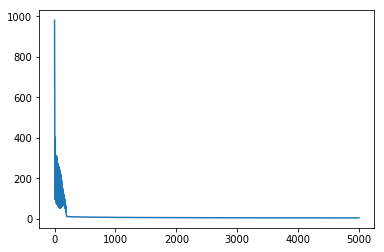

In [231]:
plt.plot(costs)

In [232]:
print(f"model accuracy: {validate_model(params,x_test,y_test)}")

model accuracy: 0.9666666666666667


sweeet!

now with l2

In [250]:
params, costs = batch_grad_desc(x_train,
                                y_train, 
                                n_iter=5000, 
                                report_frequency=500,
                                regularisation=True,
                                early_stopping=False,
                                alpha = 0.1
                               )

iteration: 0
entropy loss: 154.10803541328187

iteration: 500
entropy loss: 35.16171257960472

iteration: 1000
entropy loss: 36.69701915294315

iteration: 1500
entropy loss: 38.347774721608005

iteration: 2000
entropy loss: 39.900175668672

iteration: 2500
entropy loss: 41.33730566609721

iteration: 3000
entropy loss: 42.671639620545555

iteration: 3500
entropy loss: 43.918566170574174

iteration: 4000
entropy loss: 45.09149987049261

iteration: 4500
entropy loss: 46.201346107398564




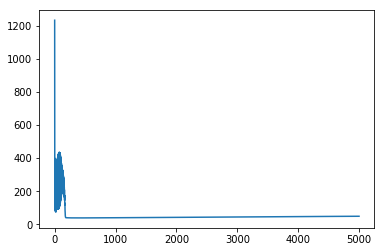

In [224]:
plt.plot(costs)

In [216]:
print(f"model accuracy: {validate_model(params,x_test,y_test)}")

model accuracy: 0.9666666666666667


In [254]:
params, costs = batch_grad_desc(x_train,
                                y_train,
                                x_test,
                                y_test,
                                n_iter=5000, 
                                report_frequency=500,
                                regularisation=False,
                                alpha = 0.1
                               )

iteration: 0
entropy loss: 1210.5483018999767

Early Stopping!
iteration: 2
entropy loss: 81.31173679151011




interesting we get greater loss, but the same accuracy